In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import math  

Using TensorFlow backend.


In [35]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(sqs, lag):
    cols, names = list(), list()
    #F = sqs.drop(columns={"date"}, axis=1)
    F = sqs
    columns = F.columns
    n_var = F.shape[1]
    for i in range(lag, 0, -1):
        cols.append(F.shift(i))
        names +=([(columns[j]+'_t-%d' % i) for j in range(n_var)])
    cols.append(F)
    names += F.columns.tolist()
    reframed = concat(cols, axis=1)
    reframed.columns = names
    reframed = reframed.drop(reframed.columns[[0,4,8,12,-1,-2]], axis=1)
    return reframed

In [6]:
#scale the data into the desirable range
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, test_X, yhat):
    predictions = list()
    for i in range(len(yhat)):
        y = yhat[i]
        X = test_X[i, :]
        new_row = [x for x in X] + [y]
        array = np.array(new_row)
        array = array.reshape(1, len(array))
        inverted = scaler.inverse_transform(array)
        y =inverted[0, -1]
        predictions.append(y)
    return predictions

In [8]:
# build the lstm model
def fit_lstm(frequency, train,time_step, batch_size, neurons):
    mean_loss = 0
    #generate training and validation dataset.
    x_train, y_train = train[:-3*frequency, 3*(frequency-time_step):-1], train[:-3*frequency, -1]
    x_train = x_train.reshape(x_train.shape[0], time_step, 3)
    x_val, y_val = train[-3*frequency:, 3*(frequency-time_step):-1], train[-3*frequency:, -1]
    x_val = x_val.reshape(x_val.shape[0], time_step, 3)
    model = Sequential()
    model.add(LSTM(units = neurons, batch_input_shape=(batch_size, time_step, 3), 
                   stateful=True, return_sequences = True))
    model.add(LSTM(units = neurons, return_sequences = False))
    model.add(Dense(units = 1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(30):
        history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0, 
                        shuffle=False, validation_data = (x_val, y_val))
        model.reset_states()
        mean_loss += min(history.history['val_loss'])
    return mean_loss/30

In [9]:
def evaluate_lstm(frequecy, train,test,time_step, batch_size, neurons):
    loss_val = np.zeros(30)
    pred_array =[]
    x_train, y_train = train[:-3*frequency, 3*(frequency-time_step):-1], train[:-3*frequency, -1]
    x_train = x_train.reshape(x_train.shape[0], time_step, 3)
    x_val, y_val = train[-3*frequency:, 3*(frequency-time_step):-1], train[-3*frequency:, -1]
    x_val = x_val.reshape(x_val.shape[0], time_step, 3)
    test_X, test_y = test[:, 3*(frequency-time_step):-1], test[:, -1]
    test_X = test_X.reshape(test_X.shape[0], time_step, 3)
    model = Sequential()
    model.add(LSTM(units = neurons, batch_input_shape=(batch_size, time_step, 3), 
                   stateful=True, return_sequences = True))
    model.add(LSTM(units = neurons, return_sequences = False))
    model.add(Dense(units = 1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=250)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    for i in range(30):
        history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0, 
                        callbacks=[es,mc],shuffle=False, validation_data = (x_val, y_val))

        # load the saved model
        saved_model = load_model('best_model.h5')
        loss_val[i] = saved_model.evaluate(test_X,test_y,batch_size,verbose = 0)
        pred = saved_model.predict(test_X, batch_size,verbose = 0)
        pred = pred.reshape(1, len(pred))
        pred_array.append(pred)
    #get the index that has the minimum loss
    idx = np.argmin(loss_val)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()
#     mean_loss += min(history.history['val_loss'])
    return (loss_val[idx],pred_array[idx])

# RNN model

In [12]:
def run_lstm(Q, n_neuron, time_step):
    # start with the quarterly data
    Qd = timeseries_to_supervised(Q, 4)
    #drop(columns={"date"}, axis=1)
    train= Qd[(Q['date'] > '1997-01-01') & (Q['date'] < '2016-01-01')].drop(columns={"date"}, axis=1).values
    test = Qd[(Q['date'] > '2016-01-01') & (Q['date'] < '2019-01-01')].drop(columns={"date"}, axis=1).values
    batch_size = 4
    scaler, train_scaled, test_scaled = scale(train, test)
    if n_neuron == 0:
        #i represent the values for neurons, 
        #j represent the values for time_step
        lstm_model = np.zeros((13,4))
        for i in range(1,14):
            for j in range(1,5):
                lstm_model[i-1,j-1] = fit_lstm(train_scaled,j, batch_size, i)
        (n_neuron, time_step)=np.unravel_index(np.argmin(lstm_model, axis=None), lstm_model.shape)
        n_neuron +=1
        time_step+=1
    # evaluate the lstm
    frequecy = 4
    (loss, PA) = evaluate_lstm(frequency,train_scaled,test_scaled,time_step, batch_size, n_neuron)
    test_X = test[:, 0:-1]
    PA_inverse = invert_scale(scaler, test_X, PA[0])
    #evaluate the model using test set.
    plt.plot(test[:,-1], color='blue', label='Actual number of patents')
    plt.plot(PA_inverse , color='red', label='Predicted number of patents')
    plt.xlabel('Date')
    plt.ylabel('Number of Patents')
    plt.legend()
    plt.show()
    return PA_inverse


## monthly data 

In [49]:
#based on the quartelry data, we can conclude that the number of hidden layer is good to be 6, then we just for loop on timeseries
# lstm_model = np.zeros(12)
# frequency = 12
# for j in range(1,13):
#     lstm_model[j-1] = fit_lstm(frequency,train_scaled,j, batch_size, 6)
# for the monthly data, the best model has time_step = 3
# print(min(lstm_model))
# print(lstm_model.argmin()+1)

0.12449128147628573
3


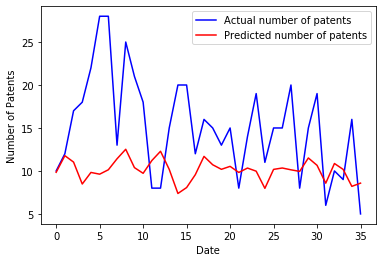

In [55]:
# for monthly data
# n_neuron = 6
# time_step = lstm_model.argmin()+1
# frequecy = 12
# (loss, PA) = evaluate_lstm(frequency,train_scaled,test_scaled,time_step, batch_size, n_neuron)
# test_X = test[:, 0:-1]
# PA_inverse = invert_scale(scaler, test_X, PA[0])
# #evaluate the model using test set.
# plt.plot(test[:,-1], color='blue', label='Actual number of patents')
# plt.plot(PA_inverse , color='red', label='Predicted number of patents')
# plt.xlabel('Date')
# plt.ylabel('Number of Patents')
# plt.legend()
# plt.show()

In [58]:
# SSE = ((test[:,-1]-PA_inverse)**2).sum()
# SSR = ((test[:,-1]-np.mean(train[:,-1]))**2).sum()
# OSR2 = 1-SSE/SSR
# RMSE = math.sqrt(np.mean((test[:,-1]-PA_inverse)**2))
# MAE = np.mean(abs((test[:,-1]-PA_inverse)))
# print("OSR2: ", OSR2)
# print("MAE: ", MAE)
# print("RMSE: ", RMSE)

OSR2:  0.6334466008297961
MAE:  6.085258161028226
RMSE:  7.660425247996444
